# Top Model

### Import Preliminaries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tqdm import *


# Prep Sample File Function
def prep_sample_submission (model_proba):
    model_proba['project_is_approved'] = 0
    for index, row in model_proba.iterrows():
        if model_proba.loc[index,0] > model_proba.loc[index,0]:
            model_proba.loc[index,'project_is_approved'] = model_proba.loc[index,0]
        else:
            model_proba.loc[index,'project_is_approved'] = model_proba.loc[index,1]
    return model_proba

pd.set_option('max_columns',1000)

### Import Data

In [2]:
# Import Data
test_data = pd.read_csv('Data/test.csv', low_memory=False)
train_data = pd.read_csv('Data/train.csv', low_memory=False)

train_df_classes = train_data['project_is_approved']

# Training Features
features = ['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories',
            'teacher_number_of_previously_posted_projects']

# Training and Testing Dataframes
train_df = train_data[features]
test_df = test_data[features]
train_df = train_df.fillna(value='No Essay')
test_df = test_df.fillna(value='No Essay')
test_ids = test_data.id

##### Encoding Values

In [3]:
for col in list(train_df.select_dtypes('object').columns):
    train_df[col] = train_df[col].astype('category')
    train_df[col] = train_df[col].cat.codes
    
for col in list(test_df.select_dtypes('object').columns):
    test_df[col] = test_df[col].astype('category')
    test_df[col] = test_df[col].cat.codes

##### Dataframe to Values

In [4]:
y = train_df_classes.values
X = train_df.values
X_test = test_df.values

## Logisical Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Train the Logistic Model
model = LogisticRegression()
model.fit(X,y)

# Predict Sample Probabilities
logpred = pd.Series(model.predict(X_test), name='project_is_approved_result')
logpred_proba = pd.DataFrame(model.predict_proba(X_test))
logpred_sample_file = prep_sample_submission(logpred_proba)
logpred_sample_file = pd.concat([test_ids,logpred_sample_file.project_is_approved], axis=1)
logpred_sample_file.to_csv('Submissions/logistic_regression_submission.csv', index=False)

# Cross Validation Score
crossvalidation = KFold(10, random_state=1)
scores = cross_val_score(model, X, y, 
                scoring = 'accuracy',
                cv = crossvalidation, n_jobs =1)

print ('Folds: %i,accuracy: %.2f std: %.2f' 
% (len(scores),np.mean(np.abs(scores)),np.std(scores)))

logpred_sample_file.head()

Folds: 10,accuracy: 0.85 std: 0.00


id  project_is_approved
0  p233245             0.837230
1  p096795             0.847115
2  p236235             0.808259
3  p233680             0.836270
4  p171879             0.854131

### Seperating Essay Data

In [6]:
# Taining Data
essay_features = ['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary']

train_edf = train_data[essay_features]
test_edf = test_data[essay_features]

# Filter Essay Features
train_edf = train_data[essay_features]
test_edf = test_data[essay_features]

# Fill DataFrame
train_edf = train_edf.fillna(value='No Essay')
test_edf = test_edf.fillna(value='No Essay')

### Single Essay Model: Preprocessing

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Model Hyper Parameters
max_features = 10000
maxlen = 500
validation_split = 0.2

# Tokenization, Sequences, Word Index, and Word Embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_edf.project_essay_1.values)
sequences = tokenizer.texts_to_sequences(train_edf.project_essay_1.values)
word_index = tokenizer.word_index
essay_one_data = pad_sequences(sequences, maxlen=maxlen)
essay_one_data = pd.DataFrame(essay_one_data)
essay_one_data = pd.concat([essay_one_data, train_df_classes], axis=1)
essay_one_data.head(10)

# Creating a list of Essay 1 features
essay_one_features = essay_one_data.columns[:-1]

# Converting DataFrame Values to Arrays
input_train = essay_one_data[essay_one_features].values
y_train = essay_one_data['project_is_approved'].values

essay_one_data.head(7)

Using TensorFlow backend.


0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  \
0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   
1  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   
2  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   
3  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   
4  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   
5  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   
6  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   

   21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  \
0   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
1   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
2   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
3   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
4   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
5   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   
6   0   0   0    0    0    0    0    0    0    0    0    0    0    0    0   

   112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [8]:
#pd.DataFrame(sequences).describe()

### Single Essay Model: Recurrent RNN in Keras

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential() 
model.add(Embedding(100000, 32))
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          3200000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,202,113
Trainable params: 3,202,113
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(input_train, y_train, epochs=1, batch_size=128, validation_split=0.2)

Train on 145664 samples, validate on 36416 samples
Epoch 1/1
145664/145664 [==============================] - 517s - loss: 0.4286 - acc: 0.8469 - val_loss: 0.4260 - val_acc: 0.8481

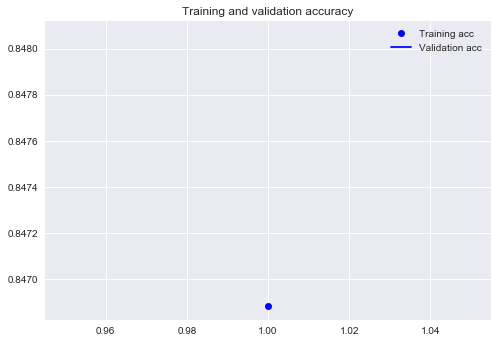

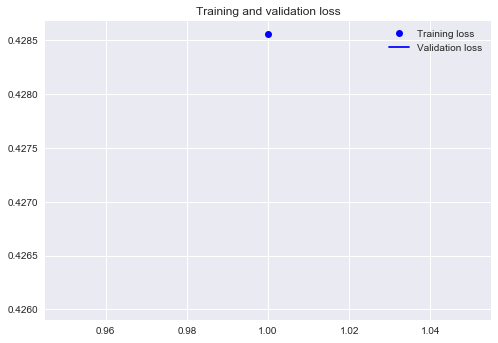

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Export Results

In [11]:
# Tokenization, Sequences, Word Index, and Word Embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_edf.project_essay_1.values)
sequences = tokenizer.texts_to_sequences(test_edf.project_essay_1.values)
essay_one_test_data = pad_sequences(sequences, maxlen=maxlen)
essay_one_test_data = pd.DataFrame(essay_one_test_data)
essay_one_test_data = pd.concat([essay_one_test_data, train_df_classes], axis=1)
essay_one_test_data.head(10)

# Converting DataFrame Values to Arrays
input_test = essay_one_test_data[essay_one_features].values


0    1    2    3    4    5    6    7    8    9   10   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    30   31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    45   46   47   48   49   50   51   52   53   54   55   56   57   58   59  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    60   61   62   63   64   65   66   67   68   69   70   71   72   73   74  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    75   76   77   78   79   80   81   82   83   84   85   86   87   88   89  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    90   91   92   93   94   95   96   97   98   99  100  101  102  103  104  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [ ]:
essay_one_test_data.sample(10)

In [12]:
pd.DataFrame(sequences).describe()

0             1             2             3             4     \
count  78035.000000  78035.000000  78035.000000  78035.000000  78035.000000   
mean     375.118575    323.277593    322.558890    476.472929    475.164606   
std     2212.626519   1758.903972   1524.032013   1893.173202   1879.877054   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       10.000000      4.000000      7.000000      8.000000      8.000000   
50%       13.000000     17.000000     17.000000     47.000000     59.000000   
75%       22.000000     76.000000    114.000000    242.000000    232.000000   
max    33977.000000  33949.000000  33968.000000  33881.000000  33886.000000   

               5             6             7             8             9     \
count  78035.000000  78035.000000  78035.000000  78033.000000  78026.000000   
mean     463.102608    465.517088    477.248299    489.260069    502.629226   
std     1771.155261   1698.904960   1762.053498   1729.857138   1739.351821   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       11.000000     11.000000     11.000000     11.000000     10.000000   
50%       63.000000     61.000000     59.000000     59.000000     48.000000   
75%      242.000000    255.000000    255.000000    269.000000    274.000000   
max    33944.000000  33953.000000  33885.000000  33959.000000  33929.000000   

               10            11            12            13            14    \
count  78016.000000  77997.000000  77985.000000  77975.000000  77964.000000   
mean     504.914479    489.621191    499.824710    485.812953    493.617580   
std     1813.335323   1751.512773   1732.947757   1683.861938   1720.669923   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       10.000000     10.000000      9.000000     10.000000     10.000000   
50%       52.000000     47.000000     47.000000     47.000000     49.000000   
75%      269.000000    269.000000    272.000000    280.000000    284.000000   
max    33978.000000  33735.000000  33566.000000  33941.000000  33824.000000   

               15            16            17            18            19    \
count  77954.000000  77933.000000  77918.000000  77903.000000  77878.000000   
mean     484.421864    483.636354    485.585333    479.248681    481.727150   
std     1699.998432   1655.773399   1704.124248   1692.005345   1747.411726   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       10.000000     10.000000     10.000000     10.000000     10.000000   
50%       47.000000     51.000000     50.000000     50.000000     48.000000   
75%      266.000000    280.000000    263.000000    257.000000    264.000000   
max    33798.000000  33854.000000  33911.000000  33943.000000  33811.000000   

               20            21            22            23            24    \
count  77856.000000  77841.000000  77807.000000  77783.000000  77752.000000   
mean     473.656147    461.870634    471.090056    474.483525    479.794745   
std     1670.923565   1633.148731   1698.247371   1663.212083   1713.114623   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       10.000000     10.000000     10.000000     10.000000     10.000000   
50%       48.000000     47.000000     46.000000     47.000000     46.000000   
75%      263.000000    257.000000    263.000000    260.000000    263.000000   
max    33899.000000  33577.000000  33835.000000  33449.000000  33836.000000   

               25            26            27            28            29    \
count  77725.000000  77699.000000  77670.000000  77645.000000  77617.000000   
mean     484.801390    477.141173    480.139449    474.473038    476.187433   
std     1697.658562   1616.199342   1693.150721   1697.024874   1633.221921   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%       10.000000     10.000000     10.000000     10.00000

In [ ]:
essay_one_test_data.describe()

In [13]:
essay_one_pred = pd.DataFrame(model.predict(input_test))
essay_one_pred.head(5)

InvalidArgumentError: indices[19,0] = -2147483648 is not in [0, 100000)
	 [[Node: embedding_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_1/embeddings/read, embedding_1/Cast)]]

Caused by op 'embedding_1/Gather', defined at:
  File "/Users/kavisekhon/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kavisekhon/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-aa5bcf9e381e>", line 5, in <module>
    model.add(Embedding(100000, 32))
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/keras/models.py", line 436, in add
    layer(x)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/keras/layers/embeddings.py", line 134, in call
    out = K.gather(self.embeddings, inputs)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1114, in gather
    return tf.gather(reference, indices)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1207, in gather
    validate_indices=validate_indices, name=name)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kavisekhon/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[19,0] = -2147483648 is not in [0, 100000)
	 [[Node: embedding_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_1/embeddings/read, embedding_1/Cast)]]


In [ ]:
essay_one_pred.columns = ['project_is_approved']
essay_one_pred_sample_file = pd.concat([test_ids,essay_one_pred], axis=1)
essay_one_pred_sample_file.to_csv('Submissions/Essay_one_predictions.csv', index=False)
essay_one_pred_sample_file.tail(10)

In [ ]:
logpred_sample_file = pd.concat([test_ids,logpred_sample_file.project_is_approved], axis=1)
logpred_sample_file.to_csv('Submissions/logistic_regression_submission.csv', index=False)

### Encoding all the Data